This notebook analyses Indian Pm Mr. Narendra Modi's speeches to understand linguistic patterns in them.

# Preprocessing

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import matplotlib.pyplot as plt

speeches = pd.read_csv("mann_ki_baat.csv", encoding='latin1')
speeches.head()

,Speech_text,month,year
0,"My Dear Countrymen,\r\nNamaskar!\r\nI was not ...",apr,2015
1,"My dear fellow citizens, Namaskar!\r\nIts sum...",apr,2016
2,My dearest countrymen namaskar. Before each ep...,apr,2017
3,"My dear countrymen, greetings to all of you! I...",aug,2015
4,"My dear countrymen, Namaskar,\r\nTomorrow, 29t...",aug,2016


In [2]:
"""
Cleaning data to remove any special characters.

@Author - Aryan Singh
"""
def clean(text):
     return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

In [3]:
speeches['Speech_text'] = speeches['Speech_text'].apply(lambda x: clean(x))
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
Speech_text    36 non-null object
month          36 non-null object
year           36 non-null int64
dtypes: int64(1), object(2)
memory usage: 944.0+ bytes


## Unigram and Bigram Frequency

We will start with word frequency and identified the most used words in the speeches.

In [4]:
def get_words_freq(words_freq):
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words,count = zip(*words_freq[:30])
    idx = np.arange(len(words))
    return words, count, idx

In [5]:
speech_txt = speeches['Speech_text']
vect = CountVectorizer(ngram_range=(1,2), analyzer='word',stop_words='english')
vect.fit(speech_txt)
bag_of_words = vect.transform(speech_txt)
bag_of_words[0,0:]
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
words, count, idx = get_words_freq(words_freq)

from matplotlib import pyplot as plt
plt.style.use('ggplot')

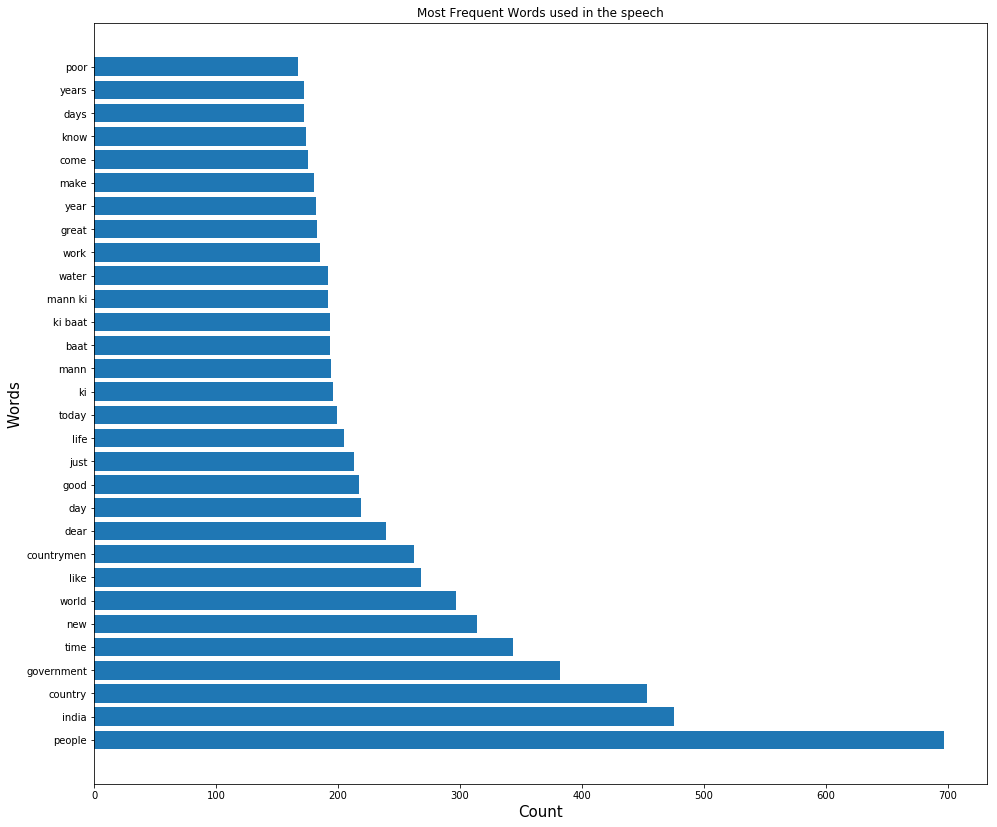

In [6]:
plt.figure(figsize=(16,14))
plt.barh(idx, count)
plt.ylabel('Words', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.yticks(idx, words, fontsize=10)
plt.title('Most Frequent Words used in the speech')
plt.show()

Since **mann ki baat** is a program aimed at listening to and addressing problems of people PMs main focus is on issues relating to poverty and water. Also he talks about taking actions by using phrases like time, make, great.

## Most Frequent Nouns, Adjective and Verbs

First we will do POS tagging. for the required parts of speech namely noun, adjectives and words.

In [46]:
import nltk
from nltk.tag import *
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.update(['My','many','new','much','dear','say', 'see','going','Mann','Ki','Baat','things','days','time','year','years','something','go','get','want','come','become','came'])
"""
Function that returns top n count of POS tags from a text

@Author
Aryan Singh
"""
def get_pos_tags(text, tag_needed, num_needed):
    wordsList = [w for w in text.split() if not w in stop_words] 
    tagged_sent = pos_tag(wordsList)
    tags = []
    if('noun' == tag_needed):
            tags = [word for word,pos in tagged_sent if pos == 'NNP' or pos=='NN'  or pos=='NNS'  or pos=='NNPS']   
    elif('verb' == tag_needed):
            tags = [word for word,pos in tagged_sent if pos == 'VB' or pos=='VBD'  or pos=='VBG'  or pos=='VBN' or pos == 'VBP' or pos=='VBZ']   
    elif('adjective' == tag_needed):
            tags = [word for word,pos in tagged_sent if pos == 'JJ' or pos=='JJR'  or pos=='JJS']   
    freq_tags = nltk.FreqDist(tags)
    return freq_tags.most_common(num_needed)

"""
Function that returns top n count of POS tags in form of a dictionary from a df column

@Author
Aryan Singh
"""
def get_frequent_pos_df(df, text_col, tag_needed, num_needed):
    df[tag_needed] = df[text_col].apply(lambda txt: get_pos_tags(txt, tag_needed, 10))
    tag_map = {}
    top_tag_map = {}
    for index, row in df.iterrows():
        for word_tup in row[tag_needed]:
            word = word_tup[0]
            count = word_tup[1]
            if word in tag_map:
                tag_map[word] = tag_map[word] + count
            else:
                tag_map[word] = count
    for k in sorted(tag_map, key=tag_map.get, reverse=True)[:num_needed]:
        top_tag_map[k] =  tag_map[k] 
    return top_tag_map

In [47]:
nouns = get_frequent_pos_df(speeches,'Speech_text','noun',16)
verbs = get_frequent_pos_df(speeches,'Speech_text','verb',16)
adjectives = get_frequent_pos_df(speeches,'Speech_text','adjective',16)

## Building the word cloud

Now lets build the word cloud to understand the top issues PM addressed in recent programmes.

In [48]:
"""
Function that generates a wordcloud from the frequency map

@Author
Aryan Singh
"""
def get_word_cloud_from_freq(freq_map):
    from wordcloud import WordCloud
    wordcloud = WordCloud(background_color="white", max_font_size=40).generate_from_frequencies(freq_map)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Nouns Cloud:


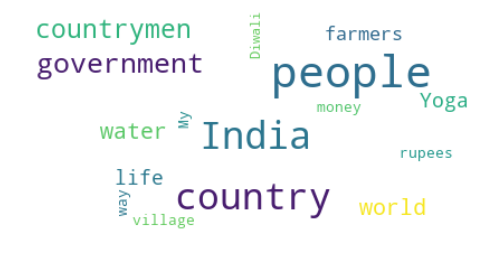

Verbs Cloud:


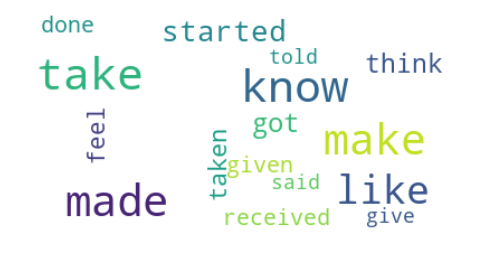

Adjective Cloud:


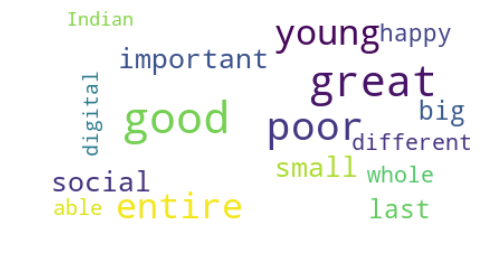

In [52]:
from IPython.display import display, HTML
print('Nouns Cloud:')
get_word_cloud_from_freq(nouns)
display(HTML('<h5>It is clear from the word cloud that the main issues that are being highlighted are related to basic ' + 
             'amenities like water, villages, farmers. Interestingly enough, yoga is repeatedly a frequent part of the '+ 
             'conversation. PM has also addressed issues about black money but the frequency is on the lower side.</h5>'))
print('Verbs Cloud:')
get_word_cloud_from_freq(verbs)
display(HTML('<h5>The verbs mostly have a positive connotation. Words like think, make, started and done indicate the ' + 
             'action oriented approach.</h5>'))
print('Adjective Cloud:')
get_word_cloud_from_freq(adjectives)
display(HTML('<h5>Adjectives do reveal a basic essence of the major fields/issues that PM is targetting. ' + 
             'Youth, poor and digital India initiatives are some of the most frequent areas touched upon.</h5>'))

## Sentiment Analysis Of The Speeches

Now let's analyse each speech for it's sentiment score to understand whether the connotation is positive/negative and how it has changed overtime.

In [86]:
from textblob import TextBlob

def get_sentiment(txt):
    analysis = TextBlob(txt)
    sentiment = analysis.sentiment[0]
    return round(sentiment,2)

In [87]:
speeches['sentiment'] = speeches['Speech_text'].apply(lambda x: get_sentiment(x))

In [88]:
speeches.head()

,Speech_text,month,year,sentiment
0,My Dear Countrymen Namaskar I was not feeling ...,apr,2015,0.10
1,My dear fellow citizens Namaskar It s summer E...,apr,2016,0.21
2,My dearest countrymen namaskar Before each epi...,apr,2017,0.22
3,My dear countrymen greetings to all of you I h...,aug,2015,0.17
4,My dear countrymen Namaskar Tomorrow 29th Augu...,aug,2016,0.17


In [89]:
month_dict = {'jan':1, 'feb':2, 'mar':3, 'apr':4,'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
speeches['month'] = speeches.month.map(month_dict)

In [90]:
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
Speech_text    36 non-null object
month          36 non-null int64
year           36 non-null int64
sentiment      36 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ KB


In [91]:
speeches['date'] = pd.to_datetime(speeches.assign(day=1).loc[:, ['year','month','day']])

In [92]:
speeches = speeches.sort_values('date')
speeches['date_str'] = speeches.date.apply(lambda x: x.strftime('%Y-%m-%d'))

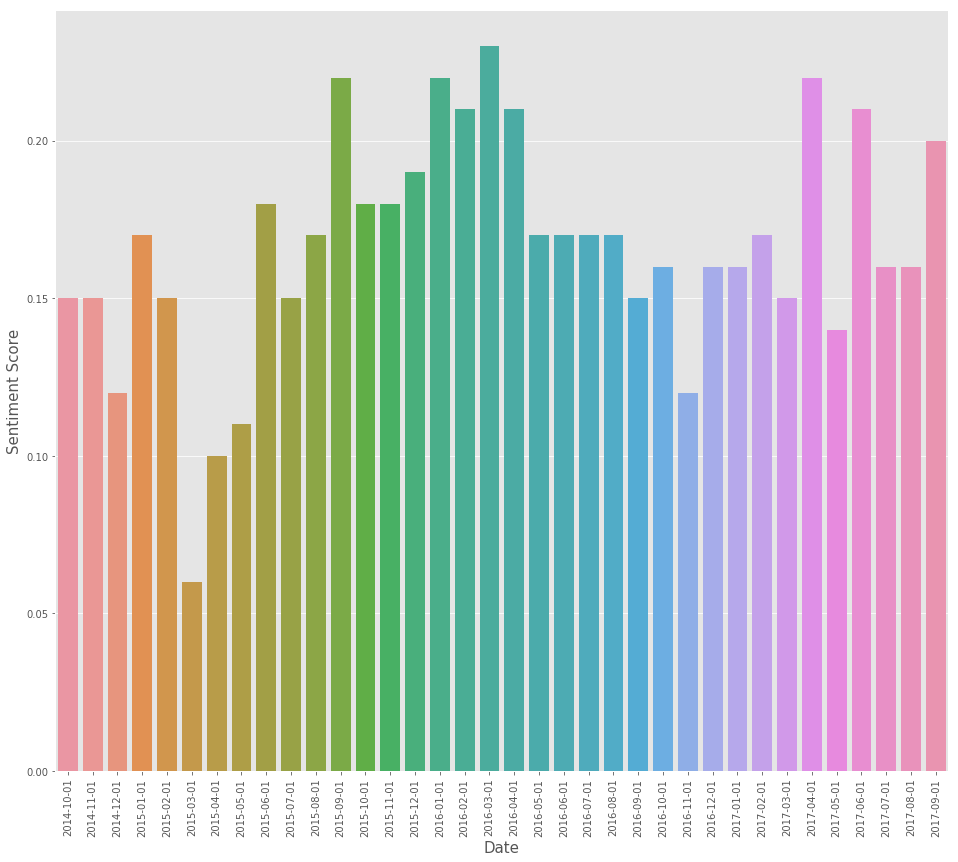

In [97]:
import seaborn as sns

plt.figure(figsize=(16,14))
sns.barplot(x='date_str',y='sentiment', data=speeches)
plt.xticks(rotation=90)
plt.ylabel('Sentiment Score', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.show()

Looking at the overall analysis, the speeches don't seem to be that positive. This might be because they are aimed at addressing the issues people face on daily basis. Overall years 2015 and 2016 are more positive as compared to the other years.